In [1]:
##############################################################################################################
### make_synthetic_data_plots.py - python script to create synthetic data and related plots
### Project started May 2017, last update Jan 2020
##############################################################################################################

import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(1, 'code/synthetic_data_and_moea_plots/')

### Project functions ###
import functions_clean_data
import functions_synthetic_data
import functions_revenues_contracts

sns.set_style('white')
sns.set_context('paper', font_scale=1.55)

eps = 1e-13
startTime = datetime.now()

dir_downloaded_inputs = './data/downloaded_inputs/'
dir_generated_inputs = './data/generated_inputs/'
dir_figs = './figures/'

cmap = cm.get_cmap('viridis')
col = [cmap(0.1),cmap(0.3),cmap(0.6),cmap(0.8)]

### Get and clean data
print('Reading in data..., ', datetime.now() - startTime)
# SWE
importlib.reload(functions_clean_data)
swe = functions_clean_data.get_clean_swe(dir_downloaded_inputs)

# hydro generation (GWh/mnth)
gen = functions_clean_data.get_historical_generation(dir_downloaded_inputs, swe).reset_index()

# wholesale power price ($/MWh), inflation adjusted
power = functions_clean_data.get_historical_power(dir_downloaded_inputs)

# SFPUC fin year sales and rates
hp_GWh, hp_dolPerKwh, hp_dolM = functions_clean_data.get_historical_SFPUC_sales()




### Generate synthetic time series
# # SWE, Feb 1 & Apr 1
print('Generating synthetic swe..., ', datetime.now() - startTime)
importlib.reload(functions_synthetic_data)
sweSynth = functions_synthetic_data.synthetic_swe(dir_generated_inputs, swe, redo = False, save = True)

# monthly generation, dependent on swe. Will also create fig S2, showing fitted models (gen as fn of swe) for each month.
print('Generating synthetic hydropower generation..., ', datetime.now() - startTime)
genSynth = functions_synthetic_data.synthetic_generation(dir_generated_inputs, dir_figs, gen, sweSynth,
                                                         redo = False, save = False, plot = True)


# monthly power price
print('Generating synthetic power prices..., ', datetime.now() - startTime)
importlib.reload(functions_synthetic_data)
powSynth = functions_synthetic_data.synthetic_power(dir_generated_inputs, power, redo = False, save = False)




### Simulate revenues and hedge payouts
# monthly revenues for SFPUC model
print('Generating simulated revenues..., ', datetime.now() - startTime)
importlib.reload(functions_revenues_contracts)
revHist, powHistSample, revSim = functions_revenues_contracts.simulate_revenue(dir_generated_inputs, gen, hp_GWh,
                                                                           hp_dolPerKwh, genSynth, powSynth,
                                                                           redo = False, save = False)


# get index from swe/revenue relationship.
nYr = int(len(revSim) / 12)
yrSim = np.full((1, nYr * 12), 0)
for i in range(1, nYr):
  yrSim[0, (12 * i):(12 * (i + 1))] = i
revSimWyr = revSim.groupby(yrSim[0, :(nYr * 12)]).sum()
revHistWyr = revHist.groupby('wyear').sum()
genSynthWyr = genSynth.groupby(yrSim[0, :(nYr * 12)]).sum()
genHistWyr = gen.groupby(yrSim[0, :len(powHistSample)]).sum()
powSynthWyr = powSynth.groupby(yrSim[0, :(nYr * 12)]).mean()
powHistWyr = powHistSample.groupby(yrSim[0, :len(powHistSample)]).mean()

lmRevSWE = sm.ols(formula='rev ~ sweFeb + sweApr', data=pd.DataFrame(
  {'rev': revSimWyr.values, 'sweFeb': sweSynth.danFeb.values,
   'sweApr': sweSynth.danApr.values}))
lmRevSWE = lmRevSWE.fit()
# print(lmRevSWE.summary())

sweWtParams = [lmRevSWE.params[1]/(lmRevSWE.params[1]+lmRevSWE.params[2]), lmRevSWE.params[2]/(lmRevSWE.params[1]+lmRevSWE.params[2])]
sweWtSynth = (sweWtParams[0] * sweSynth.danFeb + sweWtParams[1] * sweSynth.danApr)

genSynth['sweWt'] = (sweWtParams[0] * genSynth.sweFeb + sweWtParams[1] * genSynth.sweApr)
gen['sweWt'] = (sweWtParams[0] * gen.sweFeb + sweWtParams[1] * gen.sweApr)


### fixed cost parameters
meanRevenue = np.mean(revSimWyr)
fixedCostFraction =  0.914

Reading in data...,  0:00:00.000857
Generating synthetic swe...,  0:00:01.411628
Generating synthetic hydropower generation...,  0:00:01.504804
Generating synthetic power prices...,  0:00:03.601534
Generating simulated revenues...,  0:00:04.712272


In [2]:
def plot_SweFebApr_SweGen_SweRev(dir_figs, swe, gen, revHist, sweSynth, genSynth, revSim, sweWtParams,
                                MEAN_REVENUE, COST_FRACTION, histRev):
    nYr = int(len(revSim) / 12)
    yrSim = np.full((1, nYr * 12), 0)
    for i in range(1, nYr):
        yrSim[0, (12 * i):(12 * (i + 1))] = i
    revSimWyr = revSim.groupby(yrSim[0, :(nYr * 12)]).sum()
    revHistWyr = revHist.groupby('wyear').rev.sum()
    revSimWyr = revSimWyr - MEAN_REVENUE*COST_FRACTION
    revHistWyr = revHistWyr - MEAN_REVENUE*COST_FRACTION

    genSynthWyr = genSynth.groupby('wyr').sum()
    genWyr = gen.groupby('wyear').sum()

    sweWtSynth = (sweWtParams[0] * sweSynth.danFeb + sweWtParams[1] * sweSynth.danApr)
    sweWtHist = (sweWtParams[0] * swe.danFeb + sweWtParams[1] * swe.danApr)
    genSynthWyr['sweWt'] = (sweWtParams[0] * genSynthWyr['sweFeb'] + sweWtParams[1] * genSynthWyr['sweApr'])
    genWyr['sweWt'] = (sweWtParams[0] * genWyr['sweFeb'] + sweWtParams[1] * genWyr['sweApr'])

    fig = plt.figure(figsize=(8.5,3))
    gs1 = fig.add_gridspec(nrows=1, ncols=3, left=0, right=1, wspace=0.6, hspace=0.)

    ax = fig.add_subplot(gs1[0,0])
    ax.annotate('a)', xy=(0.01, 0.89), xycoords='axes fraction')
    ax.set_xlabel('Feb 1 SWE (inch)')
    ax.set_ylabel('Apr 1 SWE (inch)')
#     ax.xaxis.set_label_position('top')
    ax.set_xticks(np.arange(0,76,25))
    ax.set_yticks(np.arange(0,76,25))
#     ax.tick_params(axis='x', which='both', labelbottom=False, labeltop=True)
    ax.scatter(sweSynth.danFeb.iloc[:500], sweSynth.danApr.iloc[:500], marker='o', facecolors='none',
              linewidth=1, alpha=0.7, edgecolors=col[3], s=30)
    ax.scatter(swe.danFeb, swe.danApr, color=col[0], alpha=0.6, marker='^', s=40)

    ax0 = fig.add_subplot(gs1[0,1], sharex=ax)
    ax0.annotate('b)', xy=(0.01, 0.89), xycoords='axes fraction')
    ax0.set_xlabel('SWE Index (inch)')
    ax0.set_ylabel('Generation (TWh/yr)')
    ax0.set_xticks(np.arange(0,76,25))
    p1 = ax0.scatter(sweWtSynth.iloc[:500], genSynthWyr.gen.iloc[:500]/1000, marker='o', facecolors='none',
              linewidth=1, alpha=0.7, edgecolors=col[3], s=30)
    p2 = ax0.scatter(sweWtHist.loc[1988:], genWyr.tot/1000, color=col[0], alpha=0.6, marker='^', s=40)

    ax1 = fig.add_subplot(gs1[0,2], sharex=ax)
    ax1.annotate('c)', xy=(0.01, 0.89), xycoords='axes fraction')
    ax1.set_xlabel('SWE Index (inch)')
    ax1.set_ylabel('Net Revenue ($M/year)')
#     ax1.yaxis.set_label_position('right')
    ax1.set_xticks(np.arange(0,76,25))
#     ax1.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    ax1.axhline(0,ls=':',c='grey')
    ax1.scatter(sweWtSynth.iloc[:500], revSimWyr.iloc[:500], marker='o', facecolors='none',
              linewidth=1, alpha=0.7, edgecolors=col[3], s=30)
    ax1.scatter(sweWtHist.loc[1988:], revHistWyr, alpha=0.6, color=col[0], marker='^', s=40)

    ax0.legend([p1,p2],['Historic','Synthetic'], ncol=2, bbox_to_anchor=(1.27,-0.3))


In [3]:
def plot_historical_synthetic_generation_power(dir_figs, gen, genSynth, power, powSynth):
    # plot_name: include directory, no extension
    fig = plt.figure(figsize=(7,6))
    gs1 = fig.add_gridspec(nrows=2, ncols=1, left=0, right=1, wspace=0.0, hspace=0.1)
    ax = fig.add_subplot(gs1[0,0])
    ax2 = fig.add_subplot(gs1[1,0])

    # plot boxplot of generation for each wmnth
    gen['sweAprThirds'] = 'average'
    gen.sweAprThirds.loc[gen.sweWt > gen.sweWt.quantile(0.67)] = 'wet'
    gen.sweAprThirds.loc[gen.sweWt < gen.sweWt.quantile(0.33)] = 'dry'
    my_palette = {'wet': col[0], 'average': col[2], 'dry': col[3]}

    genSynth['sweAprThirds'] = 'average'
    genSynth.sweAprThirds.loc[genSynth.sweWt > gen.sweWt.quantile(0.67)] = 'wet'
    genSynth.sweAprThirds.loc[genSynth.sweWt < gen.sweWt.quantile(0.33)] = 'dry'
    
    genMonthsDry = pd.DataFrame({'wmnth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                               'meanHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: gen['tot'].loc[(gen['wmnth'] == x) & (gen.sweAprThirds == 'dry')].mean())/1000,
                               'stdHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: gen['tot'].loc[(gen['wmnth'] == x) & (gen.sweAprThirds == 'dry')].std())/1000,
                               'meanSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: genSynth['gen'].loc[(genSynth['wmnth'] == x) & (genSynth.sweAprThirds == 'dry')].mean())/1000,
                               'stdSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: genSynth['gen'].loc[(genSynth['wmnth'] == x) & (genSynth.sweAprThirds == 'dry')].std())/1000,
                               })
    genMonthsWet = pd.DataFrame({'wmnth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                               'meanHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: gen['tot'].loc[(gen['wmnth'] == x) & (gen.sweAprThirds == 'wet')].mean())/1000,
                               'stdHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: gen['tot'].loc[(gen['wmnth'] == x) & (gen.sweAprThirds == 'wet')].std())/1000,
                               'meanSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: genSynth['gen'].loc[(genSynth['wmnth'] == x) & (genSynth.sweAprThirds == 'wet')].mean())/1000,
                               'stdSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                 lambda x: genSynth['gen'].loc[(genSynth['wmnth'] == x) & (genSynth.sweAprThirds == 'wet')].std())/1000,
                               })
    genMonthsAverage = pd.DataFrame({'wmnth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                                   'meanHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                     lambda x: gen['tot'].loc[(gen['wmnth'] == x) & (gen.sweAprThirds == 'average')].mean())/1000,
                                   'stdHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                     lambda x: gen['tot'].loc[(gen['wmnth'] == x) & (gen.sweAprThirds == 'average')].std())/1000,
                                   'meanSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                     lambda x: genSynth['gen'].loc[(genSynth['wmnth'] == x) & (genSynth.sweAprThirds == 'average')].mean())/1000,
                                   'stdSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                     lambda x: genSynth['gen'].loc[(genSynth['wmnth'] == x) & (genSynth.sweAprThirds == 'average')].std())/1000,
                                   })

    #  plot monthly ranges with wet-avg-dry separated, std as error bars
    ax.tick_params(axis='x', which='both', labelbottom=False)

    ax.set_ylabel('Generation\n(TWh/month)')
    ax.set_xlim([-0.5,11.5])
    ax.set_xticks(genMonthsWet.index, ['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
    eb1 = ax.errorbar(genMonthsAverage.index-0.075, genMonthsAverage.meanHist,
                     yerr=genMonthsAverage.stdHist, color=my_palette['average'], marker = '^', ms=4, mew=1, mec=my_palette['average'],
                     linestyle='None')
    eb1[-1][0].set_linewidth(2)
    eb2 = ax.errorbar(genMonthsAverage.index+0.075, genMonthsAverage.meanSynth,
                     yerr=genMonthsAverage.stdSynth, color=my_palette['average'], marker = '^', markerfacecolor='white',
                     markeredgecolor=my_palette['average'], mew=1, ms=4,linestyle='None')
    eb2[-1][0].set_linestyle('--')
    eb2[-1][0].set_linewidth(2)
    eb3 = ax.errorbar(genMonthsDry.index-0.375, genMonthsDry.meanHist,
                     yerr=genMonthsDry.stdHist, color=my_palette['dry'], marker = 's', ms=4, mew=1, mec=my_palette['dry'],
                     linestyle='None')
    eb3[-1][0].set_linewidth(2)
    eb4 = ax.errorbar(genMonthsDry.index-0.225, genMonthsDry.meanSynth,
                     yerr=genMonthsDry.stdSynth, color=my_palette['dry'], marker = 's', markerfacecolor='white',
                     markeredgecolor=my_palette['dry'], mew=1, ms=4,linestyle='None')
    eb4[-1][0].set_linestyle('--')
    eb4[-1][0].set_linewidth(2)
    eb5 = ax.errorbar(genMonthsWet.index+0.225, genMonthsWet.meanHist,
                     yerr=genMonthsWet.stdHist, color=my_palette['wet'], marker = 'o', ms=4, mew=1, mec=my_palette['wet'],
                     linestyle='None')
    eb5[-1][0].set_linewidth(2)
    eb6 = ax.errorbar(genMonthsWet.index + 0.375, genMonthsWet.meanSynth,
                     yerr=genMonthsWet.stdSynth, color=my_palette['wet'], marker = 'o', markerfacecolor='white',
                     markeredgecolor=my_palette['wet'], mew=1, ms=4,linestyle='None')
    eb6[-1][0].set_linestyle('--')
    eb6[-1][0].set_linewidth(2)
    for i in range(12):
        ax.axvline(i + 0.5, color='lightgrey', lw=1)

    # now plot historical vs synthetic power prices
    powMonths = pd.DataFrame({'wmnth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                              'meanHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                lambda x: power['priceMean'].loc[power['wmnth'] == x].mean()),
                              'stdHist': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                lambda x: power['priceMean'].loc[power['wmnth'] == x].std()),
                              'meanSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                lambda x: powSynth['powPrice'].loc[powSynth['wmnth'] == x].mean()),
                              'stdSynth': pd.DataFrame({'dum': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})['dum'].apply(
                                lambda x: powSynth['powPrice'].loc[powSynth['wmnth'] == x].std()),
                              })
    
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Wholesale Price\n($/MWh)')
    ax2.set_xlim([-0.5,11.5])

    ax2.set_xticks(powMonths.index)
    ax2.set_xticklabels(['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])

    eb7 = ax2.errorbar(powMonths.index - 0.1, powMonths.meanHist,
                       yerr=powMonths.stdHist, color=col[0], marker = 's', ms=4, mew=1, mec=col[0], linestyle='None')
    eb7[-1][0].set_linewidth(2)
    eb8 = ax2.errorbar(powMonths.index + 0.1, powMonths.meanSynth,
                       yerr=powMonths.stdSynth, color=col[0], marker = 's', markerfacecolor='white',
                       markeredgecolor=col[0], mew=1, ms=4,linestyle='None')
    eb8[-1][0].set_linestyle('--')
    eb8[-1][0].set_linewidth(2)

    for i in range(12):
        ax2.axvline(i + 0.5, color='lightgrey', lw=1)

    leg1 = ax.legend((eb3,eb4,eb1,eb2,eb5,eb6),
                      ('Dry Historic','Dry Synthetic','Avg Historic','Avg Synthetic','Wet Historic','Wet Synthetic'),
                      bbox_to_anchor=(1.02, 0.92), ncol=1, borderaxespad=0.)
    leg2 = ax2.legend((eb7, eb8), ('Historic', 'Synthetic'), bbox_to_anchor=(1.02, 0.64), ncol=1, borderaxespad=0.)
    


Plotting validation for hydropower generation and power price (fig 4)...,  1:30:30.613620
Plotting validation for SWE Feb vs Apr, Swe index vs Generation, & Swe index vs revenues (fig 3)...,  1:30:30.627763


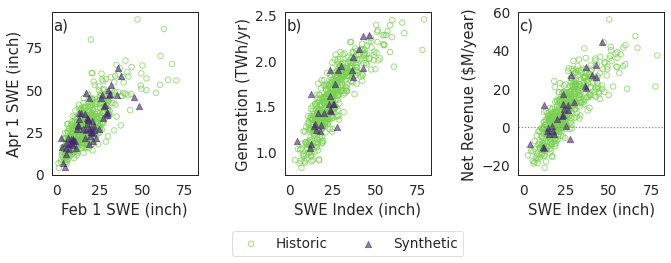

In [165]:
### plot comparing historical vs synthetic for hydro generation (as function of wetness) and for power prices
print('Plotting validation for hydropower generation and power price (fig 4)..., ', datetime.now() - startTime)
# plot_historical_synthetic_generation_power(dir_figs, gen, genSynth, power, powSynth)

### plots for SWE Feb vs Apr, Swe index vs Generation, & Swe index vs revenues
importlib.reload(functions_revenues_contracts)
print('Plotting validation for SWE Feb vs Apr, Swe index vs Generation, & Swe index vs revenues (fig 3)..., ', datetime.now() - startTime)
plot_SweFebApr_SweGen_SweRev(dir_figs, swe, gen, revHist, sweSynth, genSynth, revSim,
                                                 sweWtParams, meanRevenue, fixedCostFraction, histRev = True)

In [7]:
payoutPutSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweWtSynth, contractType='put',
                                                               lambdaRisk=0.25, strikeQuantile=0.5,
                                                               redo=True, save = False)

payoutShortCallSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweWtSynth,
                                                                     contractType='shortcall', lambdaRisk=0.25,
                                                                     strikeQuantile=0.5, redo=True, save = False)

payoutCfdSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweWtSynth, contractType = 'cfd',
                                                               lambdaRisk = 0.25, strikeQuantile = 0.5,
                                                               capQuantile = 0.95, redo = False, save = False)

payoutFebSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweSynth.danFeb, contractType = 'cfd',
                                                               lambdaRisk = 0.25, strikeQuantile = 0.5,
                                                               capQuantile = 0.95, redo = False, save = False)
payoutAprSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweSynth.danApr, contractType = 'cfd',
                                                               lambdaRisk = 0.25, strikeQuantile = 0.5,
                                                               capQuantile = 0.95, redo = False, save = False)


In [170]:
# # get unit swe payout for cfd
# def payout(swe_value, capX, capY):
#     if (swe_value >= capX):
#         return capY 
#     else:
#         return capY + (capX - swe_value)
    
# ##########################################################################
# ######### plot snow contract types (fig 5/S3) ###########
# ############## Returns figure #########################################
# ##########################################################################
# def plot_contract(dir_figs, sweFeb, sweWt, sweApr, sweWtFeb, paramCfd):

# #     strike = sweVal.quantile(0.5)
# #     prob = 1 / sweVal.shape[0]
# #     # first get prem for base case
# #     prem_base = functions_revenues_contracts.wang(pd.DataFrame({'asset': sweVal, 'prob': prob}), contractType='put', lam=0.25, k=strike, premOnly=True)
# #     for i in range(len(lambda_shifts)):
# #         lambda_shifts[i] = prem_base - functions_revenues_contracts.wang(pd.DataFrame({'asset': sweVal, 'prob': prob}), contractType='put',
# #                                             lam=lambda_shifts[i], k=strike, premOnly=True)

#     ### plot regime as function of debt and uncertain params
#     fig = plt.figure(figsize=(7,4))
#     gs1 = fig.add_gridspec(nrows=3, ncols=1, left=0, right=1, wspace=0.0, hspace=0.1)
#     ax = fig.add_subplot(gs1[0,0])
#     ax2 = fig.add_subplot(gs1[1:,0])
    
# #     ax = plt.subplot2grid((3,1), (0, 0))
#     # ax.set_xlabel('SWE Index (inch)')
#     ax.set_ylabel('Density')
#     # ax.set_xticks(np.arange(0.85, 0.98, 0.04))
#     ax.set_xlim([0,60])
# #     ax.set_ylim([0,0.04])
#     # ax.set_yticks(np.arange(0, 6))
#     ax.tick_params(axis='x', which='both', labelbottom=False,labeltop=True)
#     ax.tick_params(axis='y', which='both', labelleft=False,labelright=False)
#     # ax.xaxis.set_label_position('top')

#     sweList = [sweFeb, sweWt, sweApr]
#     labels = ['February Index','Weighted Index','April Index']
#     for p,s in enumerate(sweList):
#         sns.kdeplot(s, ax=ax, c=col[p+1], lw=2, legend=False)#, label=labels[p])
# #     ax.legend(bbox_to_anchor=(1.02, 0.03), ncol=1, borderaxespad=0.)
        
# #     ax = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
#     ax2.set_xlabel('SWE Index (inch)')
#     ax2.set_ylabel('Net Payout ($M)')
#     ax2.set_xlim([0, 60])
#     ax2.tick_params(axis='y', which='both', labelleft=False,labelright=False)
#     ax2.axhline(0, color='grey', linestyle=':')
    
#     febWtList = [1., sweWtFeb, 0.]
#     ls_list = [':','-','--']
#     for p in range(3):
#         for l in range(3):
#             capX = paramCfd[l,0]*febWtList[p]*febWtList[p] + paramCfd[l,1]*febWtList[p] + paramCfd[l,2]
#             capY = paramCfd[l,3]*febWtList[p]*febWtList[p] + paramCfd[l,4]*febWtList[p] + paramCfd[l,5]
#             ax2.plot([0, capX, 60], [capX + capY, capY, capY], color=col[p+1], linewidth=2, ls=ls_list[l])

#     line1, = ax2.plot([65,70],[0,0],c=col[1])
#     line2, = ax2.plot([65,70],[0,0],c=col[2])
#     line3, = ax2.plot([65,70],[0,0],c=col[3])
#     leg1 = ax2.legend([line1,line2,line3],['February Index','Weighted Index','April Index'],
#                loc='right', bbox_to_anchor=(1.325, 1.03), ncol=1, borderaxespad=0.)
#     ax3 = plt.gca().add_artist(leg1)
#     line1, = ax2.plot([65,70],[0,0],c='k',ls=ls_list[0])
#     line2, = ax2.plot([65,70],[0,0],c='k',ls=ls_list[1])
#     line3, = ax2.plot([65,70],[0,0],c='k',ls=ls_list[2])
#     plt.legend([line1,line2,line3],['No loading', 'Baseline loading', 'High loading'],
#                loc='right', bbox_to_anchor=(1.34, 0.48), ncol=1, borderaxespad=0.)

#     return
print(sweWtParams)

[0.3119627073670435, 0.6880372926329564]


[0.3119627073670435, 0.6880372926329564]
Plotting CFD contract with different loadings (fig 5)...,  1:34:24.679757


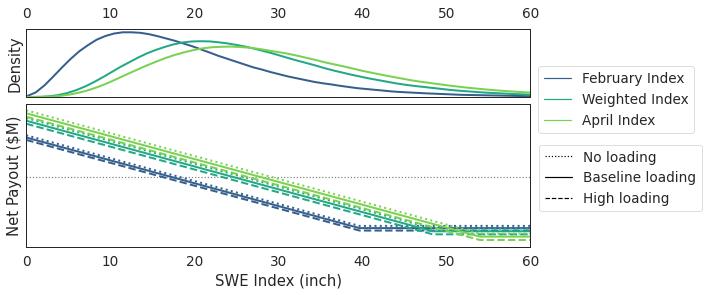

In [169]:
# param_list = pd.read_csv(dir_generated_inputs + 'param_LHC_sample_withLamPricing.txt', sep=' ')#,
#                          #header=None, names=['c','delta','Delta_fund','Delta_debt','lam','capX2','capX1','capX0','capY2','capY1','capY0'])
# param_index = [param_list.loc[param_list.lam==param_list.lam.min()].index[0], 150, param_list.loc[param_list.lam==param_list.lam.max()].index[0]]
# paramCfd = np.array(param_list.iloc[param_index, 5:])
# print(sweWtParams)

# # ### plot CFD contract with different loadings (fig 5)
# print('Plotting CFD contract with different loadings (fig 5)..., ', datetime.now() - startTime)
# # plot_contract(dir_figs, sweWtSynth, payoutPutSim, payoutShortCallSim, payoutCfdSim,
# #                                        lambda_shifts=[0., 0.5], plot_type='lambda')
# plot_contract(dir_figs, sweSynth.danFeb, sweWtSynth, sweSynth.danApr, sweWtParams[0], paramCfd)
